# Set up

In [1]:
# !pip install --upgrade huggingface_hub
# !huggingface-cli login
# !pip install datasets


If running with an Nvidia GPU make sure you type nvidia-smi into the terminal and look at the cuda version and grab the correct version of pytorch for said cuda version @ https://pytorch.org/

In [2]:
# !pip install transformers datasets #torch

In [3]:
from datasets import load_dataset
import pandas as pd
from sympy import false

Cuda check

In [4]:
import torch
import torch.nn.functional as F

print(torch.__version__)  # Should be 2.6.0+cu128
print(torch.version.cuda)  # Should show 12.8
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.device_count())  # Should be >0
print(torch.cuda.get_device_name(0))


2.8.0.dev20250318+cu128
12.8
True
1
NVIDIA GeForce RTX 4080 SUPER


Ai tweets Generated by Gpt 4o model
Prompt 1: "Create 100 [10 times] tweets from X formerly know as twitter about random topics"
Prompt 2 "Tweet about current events like politics and entertainment"

In [5]:
import pandas as pd

prompt1 = pd.read_csv('data/ai_tweets_1.txt', delimiter="\r", header=None, names=["tweet"])
prompt2 = pd.read_csv('data/ai_tweets_2.txt', delimiter='\r', header=None, names=['tweet'])
prompt1.head(10)
prompt2.head(10)

,tweet
0,Is anyone else still trying to figure out what...
1,Can’t believe the Oscar nominations are alread...
2,It's interesting to see how political campaign...
3,The rise of AI is both exciting and terrifying...
4,Heard some big things are coming from Netflix ...
5,If you’re not following the latest development...
6,The world’s carbon emissions are still rising ...
7,Did anyone watch the latest episode of The Man...
8,I’m really hoping the upcoming election debate...
9,The recent TikTok bans in various states feel ...


In [6]:
prompt1.head()

,tweet
0,Just realized that the best part of coffee is ...
1,Is it weird that I feel like my shoes are judg...
2,Sometimes the smallest things take up the most...
3,Did anyone else learn more from watching cooki...
4,Can't decide if I need a vacation or a nap. Ma...


In [7]:
prompt2.head()

,tweet
0,Is anyone else still trying to figure out what...
1,Can’t believe the Oscar nominations are alread...
2,It's interesting to see how political campaign...
3,The rise of AI is both exciting and terrifying...
4,Heard some big things are coming from Netflix ...


# setting up dair-ai emotions database

In [8]:
ds = load_dataset("dair-ai/emotion", "unsplit")

In [9]:
dair_df = pd.DataFrame(ds['train'])
dair_df = dair_df.drop(dair_df[dair_df['label'] == 2].index)
dair_df=dair_df.head(20000)
dair_df
#df = df.drop(columns=['id'])

,text,label
0,i feel awful about it too because it s my job ...,0
1,im alone i feel awful,0
2,ive probably mentioned this before but i reall...,1
3,i was feeling a little low few days back,0
6,i am one of those people who feels like going ...,1
...,...,...
21818,i struggle with feeling terrible about turning...,0
21819,i just wanted them both to just have character...,1
21820,i feel a little funny just typing all about my...,5
21821,i feel just target blank title del,0


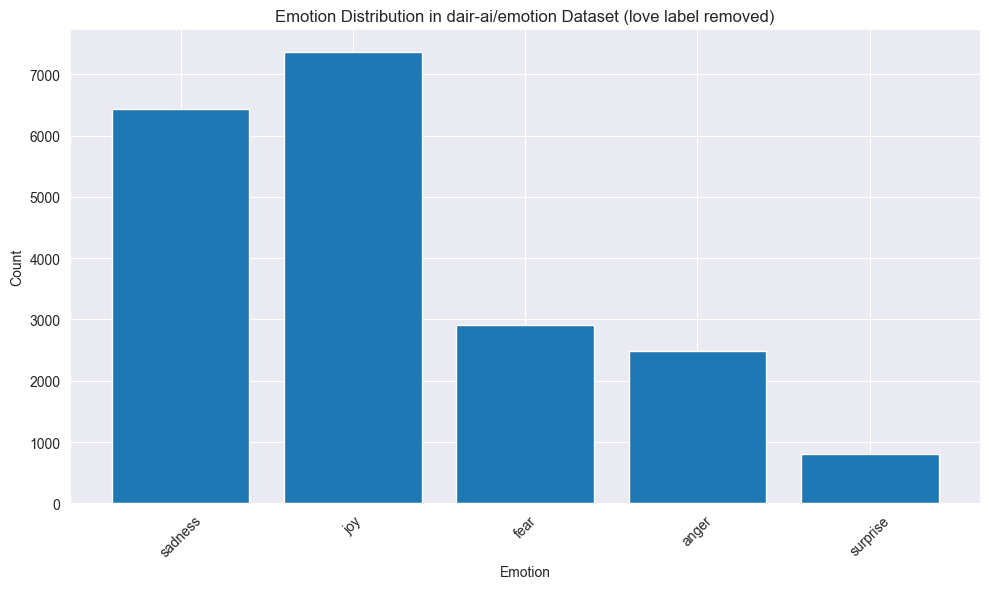

In [10]:
import matplotlib.pyplot as plt

emotion_counts = dair_df['label'].value_counts().sort_index()

# Map of label ids to emotion names (from the dataset's documentation)
label_map = {
    0: 'sadness',
    1: 'joy',
    3: 'fear',
    4: 'anger',
    5: 'surprise',
    6: 'love'
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar([label_map[i] for i in emotion_counts.index], emotion_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution in dair-ai/emotion Dataset (love label removed)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Setting up pretrained model to assess how does this model perform against upcoming self made model

j. hartmann dataclass has 5 classess since the model does not detect love and the dataset is already big we will drop all instances of love

0.  sadness
1.   joy
2.   love
3.   anger
4.   fear
5.   suprise

Maps labels to conform to go_emotions that will appear later on

In [11]:
# to conform to go_emotion data labels
dair_ai_new_label_mapping = {
    0 : 4,
    1 : 3,
 #   2 : 100,# love not used
    3 : 0,
    4 : 2,
    5 : 5
}
print(dair_ai_new_label_mapping)

{0: 4, 1: 3, 3: 0, 4: 2, 5: 5}


In [12]:
dair_df=dair_df.head(20000)
dair_df['label'] = dair_df['label'].map(dair_ai_new_label_mapping)
#smalldf['label'] = smalldf['label'].astype(int)

dair_df

,text,label
0,i feel awful about it too because it s my job ...,4
1,im alone i feel awful,4
2,ive probably mentioned this before but i reall...,3
3,i was feeling a little low few days back,4
6,i am one of those people who feels like going ...,3
...,...,...
21818,i struggle with feeling terrible about turning...,4
21819,i just wanted them both to just have character...,3
21820,i feel a little funny just typing all about my...,5
21821,i feel just target blank title del,4


# Training Dair-ai data with j-heartman model

In [13]:
# Use a pipeline as a high-level helper
from transformers import pipeline
j_hartmann = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

Device set to use cuda:0


In [14]:
j_hartmann_pred = j_hartmann(dair_df['text'].tolist())

In [15]:
j_pred_df = pd.DataFrame(j_hartmann_pred)
avg_confidence_per_emotion = j_pred_df.groupby('label')['score'].mean().sort_values(ascending=False)
print(avg_confidence_per_emotion)

label
joy         0.977351
sadness     0.960715
anger       0.940450
fear        0.935774
surprise    0.847160
disgust     0.767666
neutral     0.645637
Name: score, dtype: float64


In [16]:
dair_count =j_pred_df.groupby('label')['label'].count().sort_values(ascending=False)
print("Emotion count", dair_count)

Emotion count label
joy         7040
sadness     6253
anger       3081
fear        2632
surprise     949
disgust       31
neutral       14
Name: label, dtype: int64


J-heartmann model does pretty well on the dair-ai dataset except with neutral and disgust emotions.

# Applying j-heartmann model on AI tweets

In [17]:
ai_prompt1_j_heartmann = j_hartmann(prompt1['tweet'].tolist())
ai_prompt2_j_heartmann = j_hartmann(prompt2['tweet'].tolist())


In [18]:
prompt1_pred = pd.DataFrame(ai_prompt1_j_heartmann)
prompt2_pred = pd.DataFrame(ai_prompt2_j_heartmann)

prompt1_avg_per_emotion = prompt1_pred.groupby('label')['score'].mean().sort_values(ascending=False)
prompt2_avg_per_emotion = prompt2_pred.groupby('label')['score'].mean().sort_values(ascending=False)

print("Average emotion confidence score\n")
print("prompt 1:\n" ,prompt1_avg_per_emotion, '\n')
print("prompt 2: \n" ,prompt2_avg_per_emotion)

Average emotion confidence score

prompt 1:
 label
surprise    0.820293
joy         0.736488
neutral     0.712083
sadness     0.645157
fear        0.546071
disgust     0.517336
anger       0.455519
Name: score, dtype: float64 

prompt 2: 
 label
anger       0.739789
joy         0.728373
fear        0.711088
sadness     0.707678
surprise    0.648897
disgust     0.544976
neutral     0.353835
Name: score, dtype: float64


In [19]:
prompt1_counts = prompt1_pred['label'].value_counts()
prompt2_counts = prompt2_pred['label'].value_counts()

print("Prompt 1 - Emotion Counts:\n", prompt1_counts, '\n')
print("Prompt 2 - Emotion Counts:\n", prompt2_counts)


Prompt 1 - Emotion Counts:
 label
neutral     573
surprise    165
joy         144
sadness      70
fear         24
disgust      20
anger         4
Name: count, dtype: int64 

Prompt 2 - Emotion Counts:
 label
fear        551
joy         227
sadness      63
surprise     62
anger        46
neutral      10
disgust       1
Name: count, dtype: int64


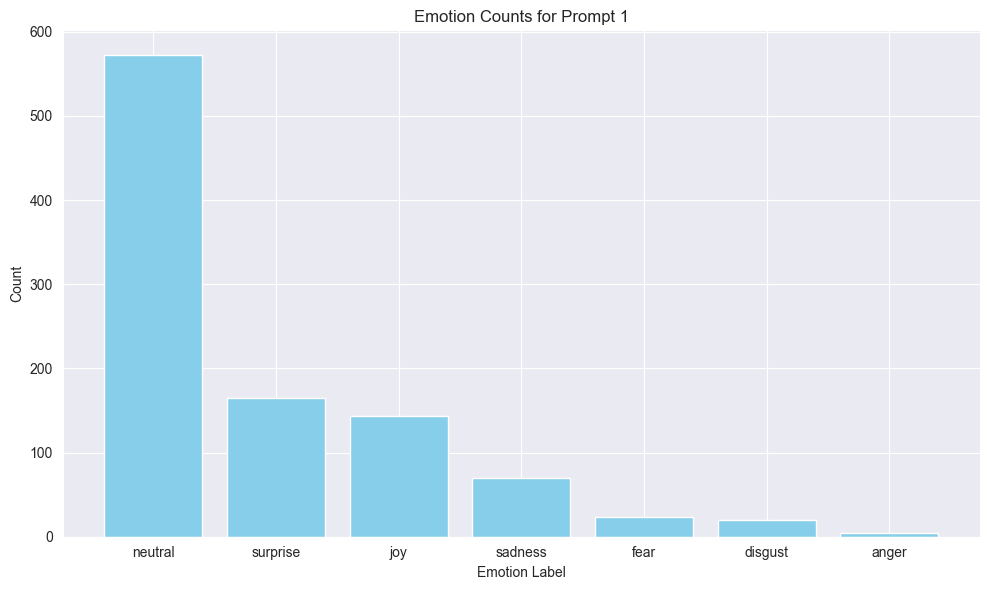

In [80]:
plt.figure(figsize=(10, 6))
plt.bar(prompt1_counts.index, prompt1_counts.values, color='skyblue')
plt.title('Emotion Counts for Prompt 1')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.xticks(prompt1_counts.index)
plt.tight_layout()
plt.show()

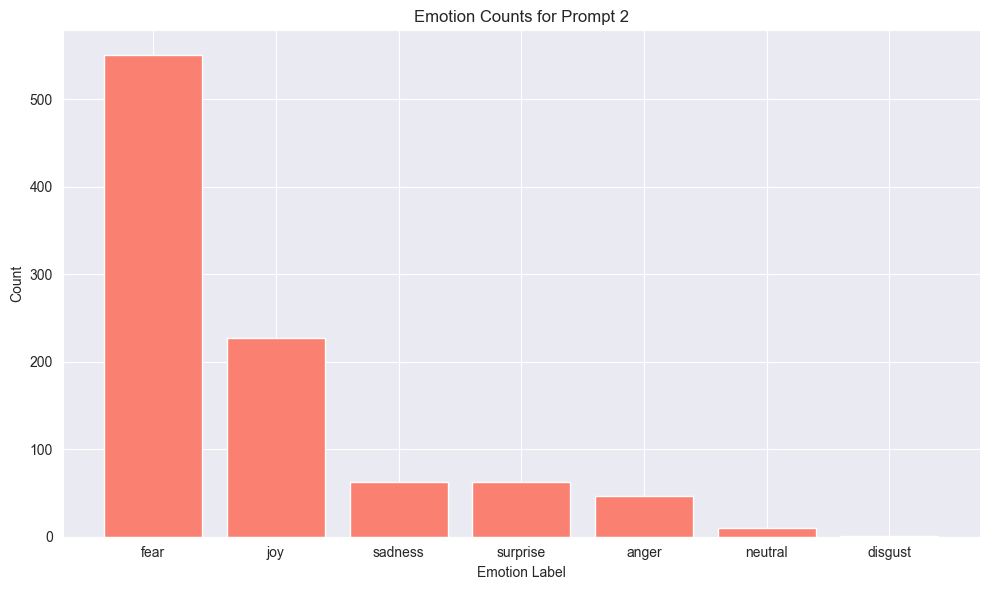

In [81]:
plt.figure(figsize=(10, 6))
plt.bar(prompt2_counts.index, prompt2_counts.values, color='salmon')
plt.title('Emotion Counts for Prompt 2')
plt.xlabel('Emotion Label')
plt.ylabel('Count')
plt.xticks(prompt2_counts.index)
plt.tight_layout()
plt.show()

Most tweets in prompt 1 are basic and thought they would fall into neutral or joy, while prompt 2 with the inclusion of politics did bring anger and fear up. A good majority of prompt 2 are also about movies that came out which explains the concentration of joy. Prompt 2 seemed more emotionally charged which does make sense. Surprised that neutral got a low score

Overall im surprised at the fact that the j-heartmann model strays away from classifying text as neutral. Perhaps its do the precise nature of the model.

# Custom model with go_emotions

In [20]:
ds = load_dataset("go_emotions", )
ds = ds.remove_columns(['id'])
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5427
    })
})


train test split

In [21]:
df1 = pd.DataFrame(ds['train'])
df2 = pd.DataFrame(ds['test'])

In [22]:
#df1 = df1.head(2000)
df2.head()

,text,labels
0,I’m really sorry about your situation :( Altho...,[25]
1,It's wonderful because it's awful. At not with.,[0]
2,"Kings fan here, good luck to you guys! Will be...",[13]
3,"I didn't know that, thank you for teaching me ...",[15]
4,They got bored from haunting earth for thousan...,[27]


In [23]:
df1.shape

(43410, 2)

In [24]:
df1.head()

,text,labels
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]
3,To make her feel threatened,[14]
4,Dirty Southern Wankers,[3]


In [25]:
df1['label_count'] = df1['labels'].apply(lambda x: len(x))  # Adjust based on your delimiter
df2['label_count'] = df2['labels'].apply(lambda x: len(x))  # Adjust based on your delimiter

# Filter out records with multiple labels
single_label_df = df1[df1['label_count'] == 1]
single_label_df2 = df2[df2['label_count'] == 1]

single_label_df = single_label_df.drop(columns=["label_count"])
single_label_df2 = single_label_df2.drop(columns=["label_count"])

# View the filtered dataset
print(single_label_df.head())

                                                text labels
0  My favourite food is anything I didn't have to...   [27]
1  Now if he does off himself, everyone will thin...   [27]
2                     WHY THE FUCK IS BAYLESS ISOING    [2]
3                        To make her feel threatened   [14]
4                             Dirty Southern Wankers    [3]


In [26]:
single_label_df.head(100)

,text,labels
0,My favourite food is anything I didn't have to...,[27]
1,"Now if he does off himself, everyone will thin...",[27]
2,WHY THE FUCK IS BAYLESS ISOING,[2]
3,To make her feel threatened,[14]
4,Dirty Southern Wankers,[3]
...,...,...
114,It's because you play against 1000 ms ping EU ...,[17]
115,Updooted like the filthy animal I am.,[27]
116,The fuck is “mog?!”,[2]
117,Especially that “Australia ain’t gonna cop it”...,[2]


In [27]:
single_label_df2.head()

,text,labels
0,I’m really sorry about your situation :( Altho...,[25]
1,It's wonderful because it's awful. At not with.,[0]
2,"Kings fan here, good luck to you guys! Will be...",[13]
3,"I didn't know that, thank you for teaching me ...",[15]
4,They got bored from haunting earth for thousan...,[27]


In [28]:
target_emtions = [25, 11, 17, 2, 14, 26, 27]

## Filter DF and keep only the labels we want
final_train = single_label_df[single_label_df['labels'].apply(lambda x: any(item in target_emtions for item in x))]
final_train['labels'] = final_train['labels'].apply(lambda x: x[0])

final_test = single_label_df2[single_label_df2['labels'].apply(lambda x: any(item in target_emtions for item in x))]
final_test['labels'] = final_test['labels'].apply(lambda x: x[0])

final_train.count()
final_train.head(100)

C:\Users\Brian\AppData\Local\Temp\ipykernel_46672\548075363.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train['labels'] = final_train['labels'].apply(lambda x: x[0])
C:\Users\Brian\AppData\Local\Temp\ipykernel_46672\548075363.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test['labels'] = final_test['labels'].apply(lambda x: x[0])


,text,labels
0,My favourite food is anything I didn't have to...,27
1,"Now if he does off himself, everyone will thin...",27
2,WHY THE FUCK IS BAYLESS ISOING,2
3,To make her feel threatened,14
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,26
...,...,...
198,Dv cus it’s playful doggos,27
200,Needs a real big bag of rice!,27
204,i think its cool because its a hybrid that com...,17
206,Ask over at r/NewTubers,27


Sadness = 25, Disgust = 11, Joy = 17, Anger = 2, Fear = 14, 26 = Supirse, Neutral = 27

In [29]:
print(final_train['labels'].unique())
label_counts = final_train.value_counts('labels').sort_index()
label_counts
# labels = [25, 11, 17, 2, 14, 26, 27]

[27  2 14 26 17 25 11]


labels
2      1025
11      498
14      430
17      853
25      817
26      720
27    12823
Name: count, dtype: int64

In [30]:
label_map = {
    25: "Sadness",
    11: "Disgust",
    17: "Joy",
    2: "Anger",
    14: "Fear",
    26: "Surprise",
    27: "Neutral"
}


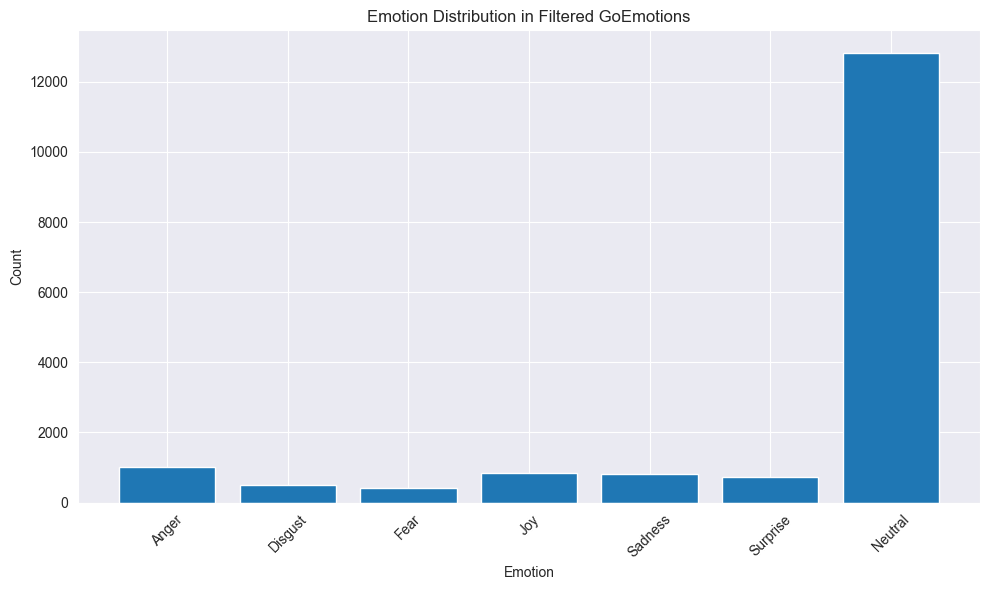

In [31]:
plt.figure(figsize=(10, 6))
plt.bar([label_map[i] for i in label_counts.index], label_counts.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution in Filtered GoEmotions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
original_labels = [25, 11, 17, 2, 14, 26, 27]
label_mapping = {label: idx for idx, label in enumerate(sorted(original_labels))}
print(label_mapping)

final_train['labels'] = final_train['labels'].apply(lambda x: label_mapping[x])
final_test['labels'] = final_test['labels'].apply(lambda x: label_mapping[x])


{2: 0, 11: 1, 14: 2, 17: 3, 25: 4, 26: 5, 27: 6}


C:\Users\Brian\AppData\Local\Temp\ipykernel_46672\1765621536.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train['labels'] = final_train['labels'].apply(lambda x: label_mapping[x])
C:\Users\Brian\AppData\Local\Temp\ipykernel_46672\1765621536.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_test['labels'] = final_test['labels'].apply(lambda x: label_mapping[x])


New Labels (also used in dair-ai dataset)

0 = Anger,
1 = Disgust,
2 = Fear,
3 = Joy,
4 = Sadness,
5 = Surprise,
6 = Neutral

In [33]:
print(label_mapping)

{2: 0, 11: 1, 14: 2, 17: 3, 25: 4, 26: 5, 27: 6}


due to the large amount of instances with the neutral label


In [34]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for the labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(final_train['labels']),
    y=final_train['labels']
)



In [35]:
from simpletransformers.config.model_args import ClassificationArgs
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs()
model_args.num_train_epochs = 3
model_args.output_dir = "outputs/"
model_args.overwrite_output_dir = True
model_args.class_weight = class_weights

model = ClassificationModel(
    #no specific reason for this choice
    model_type="roberta",
    model_name="roberta-base",
    num_labels=7,
    args=model_args,
    use_cuda=True
)

model.train_model(final_train)
result, model_outputs, wrong_preds = model.eval_model(final_test)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_7_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/2146 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/2146 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/2146 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_7_2


Running Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
INFO:simpletransformers.classification.classification_model:{'mcc': np.float64(0.6913007106778426), 'eval_loss': 0.6107225248759444}


Visualization

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


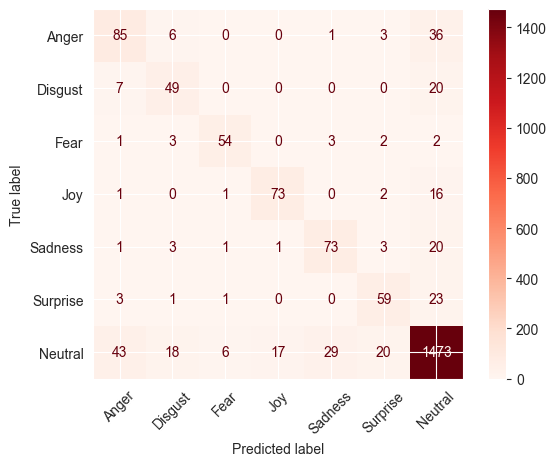

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on evaluation data
preds, _ = model.predict(final_test['text'].tolist())
# Create inverse label mapping
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
label_names = [label_map[reverse_label_mapping[i]] for i in range(len(label_mapping))]

# Plot confusion matrix
cm = confusion_matrix(final_test['labels'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45, cmap='Reds')


In [37]:
from sklearn.metrics import classification_report

print(classification_report(final_test['labels'], preds, target_names=label_names))


              precision    recall  f1-score   support

       Anger       0.60      0.65      0.62       131
     Disgust       0.61      0.64      0.63        76
        Fear       0.86      0.83      0.84        65
         Joy       0.80      0.78      0.79        93
     Sadness       0.69      0.72      0.70       102
    Surprise       0.66      0.68      0.67        87
     Neutral       0.93      0.92      0.92      1606

    accuracy                           0.86      2160
   macro avg       0.74      0.75      0.74      2160
weighted avg       0.87      0.86      0.87      2160



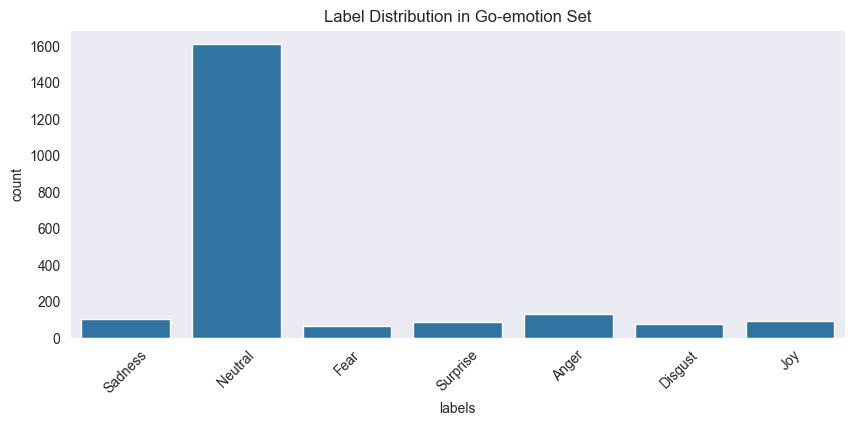

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.countplot(x=final_test['labels'].map(reverse_label_mapping).map(label_map))
plt.title("Label Distribution in Go-emotion Set")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


although the weights were added the model still shows a big bias toward the neutral class.

# AI prompts with custom model

In [39]:
ai_prompt1_pred,ai_1_raw = model.predict(prompt1['tweet'].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [40]:
ai_prompt2_pred, ai_2_raw_ = model.predict(prompt2['tweet'].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [41]:
# Convert logits to confidence scores
probs1 = F.softmax(torch.tensor(ai_1_raw), dim=1)
probs2 = F.softmax(torch.tensor(ai_2_raw_), dim=1)

In [42]:
# Get top confidence score per prediction
confidences1 = probs1.max(dim=1).values.numpy()
confidences2 = probs2.max(dim=1).values.numpy()

In [43]:
from scipy.special import softmax
# Reverse label mapping: model_index -> original_label_id
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Optional: readable label names (e.g., from label_map = {2: "anger", ...})
label_map = {2: "anger", 11: "joy", 14: "sadness", 17: "surprise", 25: "fear", 26: "disgust", 27: "neutral"}

# Prepare predictions with confidence
def format_predictions(preds, outputs):
    results = []
    for pred, logits in zip(preds, outputs):
        probs = softmax(logits)  # convert logits to probabilities
        confidence = float(probs[pred])
        orig_label_id = reverse_label_mapping[int(pred)]
        label_name = label_map[orig_label_id]
        results.append((label_name, confidence))
    return results

formatted_preds1 = format_predictions(ai_prompt1_pred, ai_1_raw)
formatted_preds2 = format_predictions(ai_prompt2_pred, ai_2_raw_)


In [44]:
# Show example results
for i, (text, (label, conf)) in enumerate(zip(prompt1['tweet'], formatted_preds1[:5])):
    print(f"[{i}] {label} ({conf:.2%})\n{text}\n")

[0] neutral (98.89%)
Just realized that the best part of coffee is that first sip. #MorningVibes

[1] neutral (82.29%)
Is it weird that I feel like my shoes are judging me when I walk into a store? 👟

[2] neutral (99.86%)
Sometimes the smallest things take up the most room in your heart. 💛 #DeepThoughts

[3] neutral (99.87%)
Did anyone else learn more from watching cooking shows than actual cooking classes? 🍳

[4] neutral (99.88%)
Can't decide if I need a vacation or a nap. Maybe both? 🌴💤



In [45]:
for i, (text, (label, conf)) in enumerate(zip(prompt2['tweet'], formatted_preds2[:5])):
    print(f"[{i}] {label} ({conf:.2%})\n{text}\n")

[0] neutral (99.77%)
Is anyone else still trying to figure out what’s going on with the Twitter rebrand to X? It’s just confusing at this point. 🤔 #X #TwitterChanges

[1] disgust (98.22%)
Can’t believe the Oscar nominations are already coming up again. 2025 is already shaping up to be a big year for movies! 🎬 #Oscars2025

[2] neutral (69.25%)
It's interesting to see how political campaigns are shifting strategies with social media. So much has changed since 2016. 📲 #Election2024

[3] sadness (98.45%)
The rise of AI is both exciting and terrifying. Who’s ready for robots taking over? 🤖 #AI #FutureTech

[4] neutral (99.78%)
Heard some big things are coming from Netflix this year. I’m hoping for a season 2 of Wednesday! 🍿 #Netflix2025



In [46]:
# Split the tuple into two clean columns
prompt1_results = prompt1
prompt1_results['emotion'] = [label for label, _ in formatted_preds1]
prompt1_results['confidence'] = [conf for _, conf in formatted_preds1]

# Split the tuple into two clean columns
prompt2_results = prompt2
prompt2_results['emotion'] = [label for label, _ in formatted_preds2]
prompt2_results['confidence'] = [conf for _, conf in formatted_preds2]



prompt1_results.to_csv("ai_predictions1.csv", columns=['tweet', 'emotion', 'confidence'], sep='|')
prompt2_results.to_csv("ai_predictions2.csv", columns=['tweet', 'emotion', 'confidence'], sep='|')

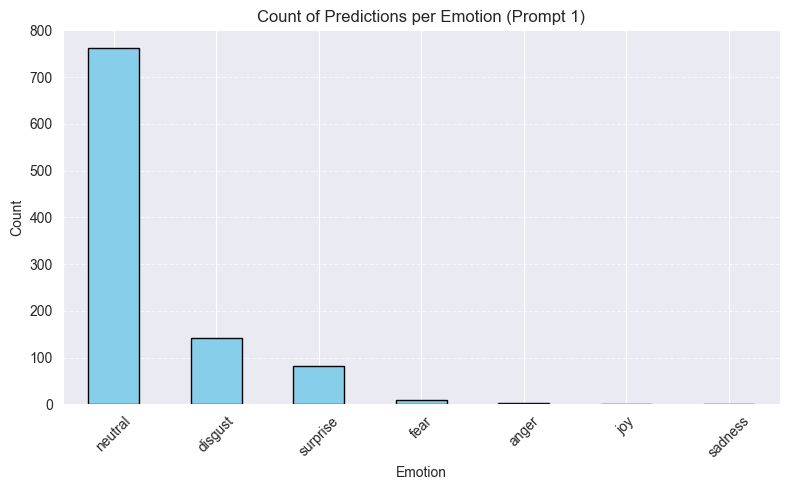

In [47]:
ai_1_output = pd.read_csv("ai_predictions1_clean.csv", delimiter='|')

emotion_counts = ai_1_output['emotion'].value_counts()
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Count of Predictions per Emotion (Prompt 1)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

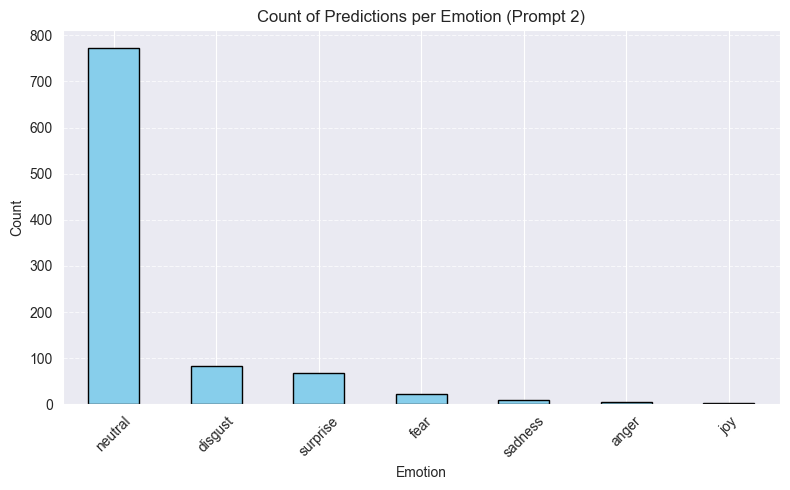

In [48]:
ai_2_output = pd.read_csv("ai_predictions2_clean.csv", delimiter='|')

emotion_counts = ai_2_output['emotion'].value_counts()
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Count of Predictions per Emotion (Prompt 2)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [49]:
# Group by emotion and calculate average confidence
avg_conf_1 = ai_1_output.groupby('emotion')['confidence'].mean().sort_values(ascending=False)
avg_conf_2 = ai_2_output.groupby('emotion')['confidence'].mean().sort_values(ascending=False)

print("Average Confidence per Emotion (Prompt 1):\n", avg_conf_1)
print("\nAverage Confidence per Emotion (Prompt 2):\n", avg_conf_2)


Average Confidence per Emotion (Prompt 1):
 emotion
sadness     0.989099
disgust     0.982839
neutral     0.980046
surprise    0.914803
anger       0.787470
fear        0.760516
joy         0.712576
Name: confidence, dtype: float64

Average Confidence per Emotion (Prompt 2):
 emotion
neutral     0.977752
sadness     0.969481
disgust     0.914754
fear        0.903510
surprise    0.902869
joy         0.901152
anger       0.607154
Name: confidence, dtype: float64


Model has more confidence while predicting emotions than the j-hartmann model but the bias is showing here for the neutral class

In [50]:
print("prompt 1:\n", prompt1_results['emotion'].value_counts(), '\n')
print("prompt 2: \n", prompt2_results['emotion'].value_counts())


prompt 1:
 emotion
neutral     733
disgust     146
surprise    100
fear         14
anger         6
sadness       1
Name: count, dtype: int64 

prompt 2: 
 emotion
neutral     745
disgust     103
surprise     65
fear         31
sadness      10
joy           3
anger         3
Name: count, dtype: int64


# Combining Models

To addresses the bias found we will combine the go-emotion dataset with the dair-ai dataset which does not have any instances with a neutral label.

In [51]:
combo_dataset = final_train
combo_dataset = pd.concat([combo_dataset, dair_df], ignore_index=True, )
combo_dataset

,text,labels,label
0,My favourite food is anything I didn't have to...,6.0,NaN
1,"Now if he does off himself, everyone will thin...",6.0,NaN
2,WHY THE FUCK IS BAYLESS ISOING,0.0,NaN
3,To make her feel threatened,2.0,NaN
4,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,5.0,NaN
...,...,...,...
37161,i struggle with feeling terrible about turning...,NaN,4.0
37162,i just wanted them both to just have character...,NaN,3.0
37163,i feel a little funny just typing all about my...,NaN,5.0
37164,i feel just target blank title del,NaN,4.0


In [52]:
combo_dataset = pd.concat([final_train[['text', 'labels']].rename(columns={'labels': 'label'}), dair_df[['text', 'label']]], ignore_index=True)
combo_dataset

,text,label
0,My favourite food is anything I didn't have to...,6
1,"Now if he does off himself, everyone will thin...",6
2,WHY THE FUCK IS BAYLESS ISOING,0
3,To make her feel threatened,2
4,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,5
...,...,...
37161,i struggle with feeling terrible about turning...,4
37162,i just wanted them both to just have character...,3
37163,i feel a little funny just typing all about my...,5
37164,i feel just target blank title del,4


In [53]:
final_train.size

34332

In [54]:
dair_df.size

40000

In [55]:
combo_dataset.shape

(37166, 2)

Reminder


0 = Anger,
1 = Disgust,
2 = Fear,
3 = Joy,
4 = Sadness,
5 = Surprise,
6 = Neutral

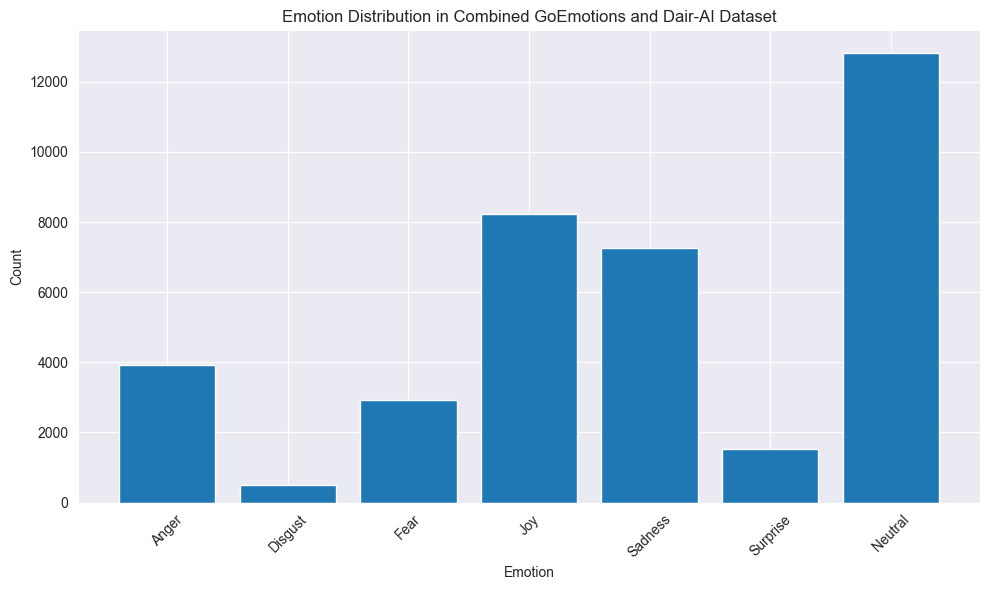

In [56]:
# Plot the emotion count for the combined dataset
emotion_counts_combo = combo_dataset['label'].value_counts().sort_index()

# Map of label ids to emotion names (same as before)
label_map = {
    0: 'Anger',
    1: 'Disgust',
    2: 'Fear',
    3: 'Joy',
    4: 'Sadness',
    5: 'Surprise',
    6: 'Neutral'
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar([label_map[i] for i in emotion_counts_combo.index], emotion_counts_combo.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotion Distribution in Combined GoEmotions and Dair-AI Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [57]:
print(combo_dataset['label'].unique())
print(combo_dataset.value_counts('label'))


[6 0 2 5 3 4 1]
label
6    12823
3     8219
4     7250
0     3932
2     2917
5     1527
1      498
Name: count, dtype: int64


Still has a lot more of the neutral class but less so

In [58]:
from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(combo_dataset, test_size=0.3, random_state=42, stratify=combo_dataset['label'])


In [59]:
combo_class_weights = compute_class_weight( # still accounting for the imbalance in the dataset
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)


In [60]:
#same model with the exception of the weight
model_args_combo = ClassificationArgs()
model_args_combo.num_train_epochs = 3
model_args_combo.output_dir = "outputs/"
model_args_combo.overwrite_output_dir = True
#model_args_combo.class_weight = combo_class_weights

model_combo = ClassificationModel(
    model_type="roberta",
    model_name="roberta-base",
    num_labels=7,
    args=model_args_combo,
    use_cuda=True
)
model_combo.train_model(train_df)

result_combo, model_outputs_combo, wrong_preds_combo = model.eval_model(eval_df)
# Predict on evaluation data

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/52 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_roberta_128_7_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:882: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


Running Epoch 1 of 3:   0%|          | 0/3252 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:905: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


Running Epoch 2 of 3:   0%|          | 0/3252 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/3252 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/22 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_dev_roberta_128_7_2


Running Evaluation:   0%|          | 0/112 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:1505: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
INFO:simpletransformers.classification.classification_model:{'mcc': np.float64(0.5653891679763611), 'eval_loss': 2.053649254143238}


In [ ]:

# # Predict on evaluation data
# preds, _ = model.predict(final_test['text'].tolist())
# # Create inverse label mapping
# reverse_label_mapping = {v: k for k, v in label_mapping.items()}
# label_names = [label_map[reverse_label_mapping[i]] for i in range(len(label_mapping))]
#
# # Plot confusion matrix
# cm = confusion_matrix(final_test['labels'], preds)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
# disp.plot(xticks_rotation=45, cmap='Reds')

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


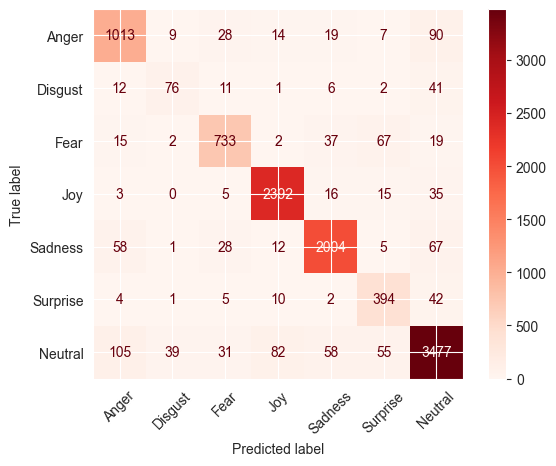

In [65]:
preds_combo, _ = model_combo.predict(eval_df['text'].tolist())  # Get the predictions

cm = confusion_matrix(eval_df['label'], preds_combo)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation=45, cmap='Reds')

# Show the plot
plt.show()

In [66]:
print(classification_report(eval_df['label'], preds_combo, target_names=label_names))


              precision    recall  f1-score   support

       Anger       0.84      0.86      0.85      1180
     Disgust       0.59      0.51      0.55       149
        Fear       0.87      0.84      0.85       875
         Joy       0.95      0.97      0.96      2466
     Sadness       0.94      0.92      0.93      2175
    Surprise       0.72      0.86      0.79       458
     Neutral       0.92      0.90      0.91      3847

    accuracy                           0.90     11150
   macro avg       0.83      0.84      0.83     11150
weighted avg       0.91      0.90      0.90     11150



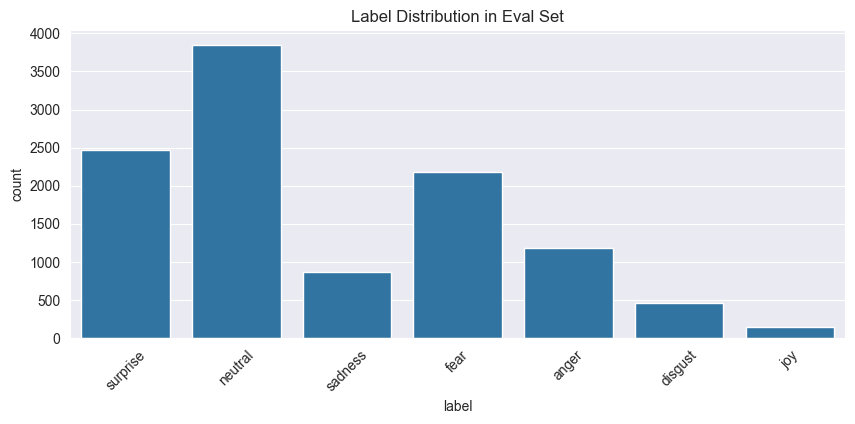

In [78]:

plt.figure(figsize=(10, 4))
sns.countplot(x=eval_df['label'].map(reverse_label_mapping).map(label_map))
plt.title("Label Distribution in Eval Set")
plt.xticks(rotation=45)
plt.show()

# Redoing Ai datasets with combo model

In [68]:
ai_prompt1_pred_combo, ai_1_raw_combo = model_combo.predict(prompt1['tweet'].tolist())
ai_prompt2_pred_combo, ai_2_raw_combo = model_combo.predict(prompt2['tweet'].tolist())

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\Brian\PyCharmMiscProject\.venv\Lib\site-packages\simpletransformers\classification\classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():
INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
# Convert logits to confidence scores
probs1_combo = F.softmax(torch.tensor(ai_1_raw), dim=1)
probs2_combo = F.softmax(torch.tensor(ai_2_raw_), dim=1)
# Get top confidence score per prediction
confidences1_combo = probs1_combo.max(dim=1).values.numpy()
confidences2_combo= probs2_combo.max(dim=1).values.numpy()

In [70]:

# Reverse label mapping: model_index -> original_label_id
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Optional: readable label names (e.g., from label_map = {2: "anger", ...})
label_map = {2: "anger", 11: "joy", 14: "sadness", 17: "surprise", 25: "fear", 26: "disgust", 27: "neutral"}


# Prepare predictions with confidence
def format_predictions(preds, outputs):
    results = []
    for pred, logits in zip(preds, outputs):
        probs = softmax(logits)  # convert logits to probabilities
        confidence = float(probs[pred])
        orig_label_id = reverse_label_mapping[int(pred)]
        label_name = label_map[orig_label_id]
        results.append((label_name, confidence))
    return results


formatted_preds1_combo = format_predictions(ai_prompt1_pred_combo, ai_1_raw_combo)
formatted_preds2_combo = format_predictions(ai_prompt2_pred_combo, ai_2_raw_combo)

In [71]:

# Show example results
for i, (text, (label, conf)) in enumerate(zip(prompt1['tweet'], formatted_preds1_combo[:5])):
    print(f"[{i}] {label} ({conf:.2%})\n{text}\n")
for i, (text, (label, conf)) in enumerate(zip(prompt2['tweet'], formatted_preds2_combo[:5])):
    print(f"[{i}] {label} ({conf:.2%})\n{text}\n")

[0] neutral (99.49%)
Just realized that the best part of coffee is that first sip. #MorningVibes

[1] neutral (95.18%)
Is it weird that I feel like my shoes are judging me when I walk into a store? 👟

[2] neutral (99.78%)
Sometimes the smallest things take up the most room in your heart. 💛 #DeepThoughts

[3] neutral (99.87%)
Did anyone else learn more from watching cooking shows than actual cooking classes? 🍳

[4] neutral (99.86%)
Can't decide if I need a vacation or a nap. Maybe both? 🌴💤

[0] neutral (99.83%)
Is anyone else still trying to figure out what’s going on with the Twitter rebrand to X? It’s just confusing at this point. 🤔 #X #TwitterChanges

[1] disgust (99.33%)
Can’t believe the Oscar nominations are already coming up again. 2025 is already shaping up to be a big year for movies! 🎬 #Oscars2025

[2] neutral (98.32%)
It's interesting to see how political campaigns are shifting strategies with social media. So much has changed since 2016. 📲 #Election2024

[3] sadness (98.90%)

In [72]:
# Split the tuple into two clean columns
prompt1_result_combo = prompt1
prompt1_result_combo['emotion'] = [label for label, _ in formatted_preds1_combo]
prompt1_result_combo['confidence'] = [conf for _, conf in formatted_preds1_combo]

# Split the tuple into two clean columns
prompt2_result_combo = prompt2
prompt2_result_combo['emotion'] = [label for label, _ in formatted_preds2_combo]
prompt2_result_combo['confidence'] = [conf for _, conf in formatted_preds2_combo]

prompt1_result_combo.to_csv("ai_predictions1_combo.csv", columns=['tweet', 'emotion', 'confidence'], sep='|')
prompt2_result_combo.to_csv("ai_predictions2_combo.csv", columns=['tweet', 'emotion', 'confidence'], sep='|')

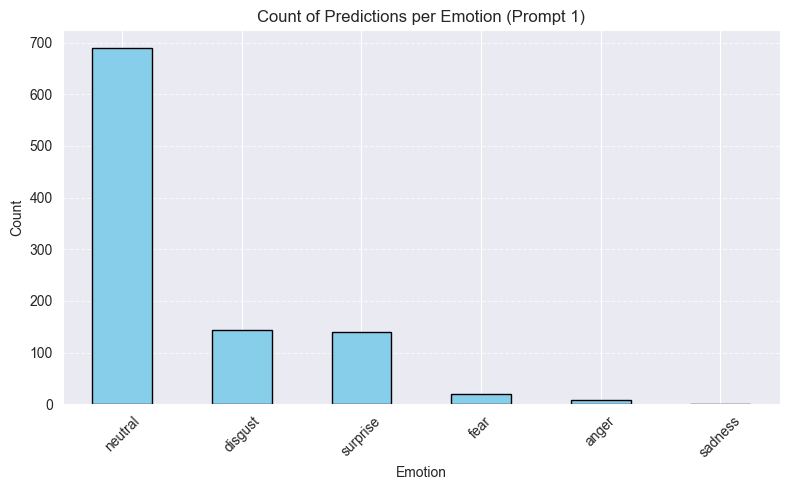

In [73]:
ai_1_output_combo = pd.read_csv("ai_predictions1_combo.csv", delimiter='|')

emotion_counts = ai_1_output_combo['emotion'].value_counts()
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Count of Predictions per Emotion (Prompt 1)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

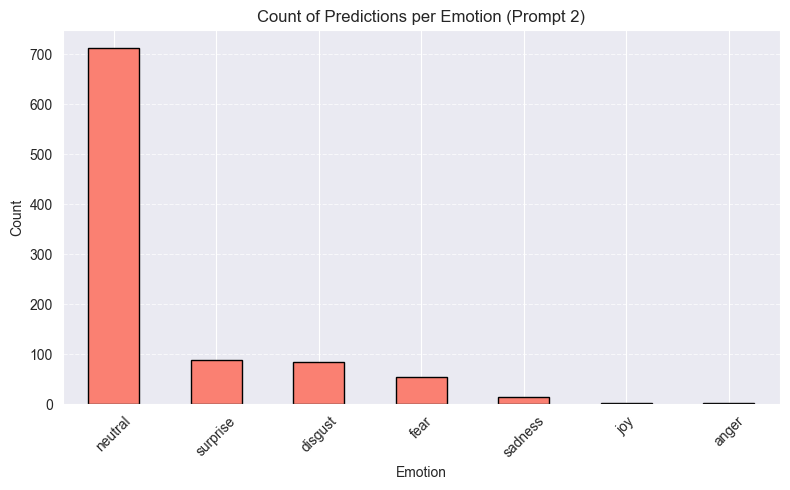

In [82]:
ai_2_output_combo = pd.read_csv("ai_predictions2_combo.csv", delimiter='|')

emotion_counts = ai_2_output_combo['emotion'].value_counts()
plt.figure(figsize=(8, 5))
emotion_counts.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Count of Predictions per Emotion (Prompt 2)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [75]:
# Group by emotion and calculate average confidence
avg_conf_1_combo = ai_1_output_combo.groupby('emotion')['confidence'].mean().sort_values(ascending=False)
avg_conf_2_combo = ai_2_output_combo.groupby('emotion')['confidence'].mean().sort_values(ascending=False)

print("Average Confidence per Emotion (Prompt 1):\n", avg_conf_1_combo)
print("\nAverage Confidence per Emotion (Prompt 2):\n", avg_conf_2_combo)


Average Confidence per Emotion (Prompt 1):
 emotion
disgust     0.984102
neutral     0.975101
surprise    0.950658
fear        0.931004
sadness     0.930242
anger       0.892835
Name: confidence, dtype: float64

Average Confidence per Emotion (Prompt 2):
 emotion
joy         0.977644
neutral     0.973653
sadness     0.940858
fear        0.931484
disgust     0.928605
surprise    0.897843
anger       0.628153
Name: confidence, dtype: float64


In [76]:
print("prompt 1:\n", prompt1_results['emotion'].value_counts(), '\n')
print("prompt 2: \n", prompt2_results['emotion'].value_counts())


prompt 1:
 emotion
neutral     689
disgust     143
surprise    139
fear         20
anger         8
sadness       1
Name: count, dtype: int64 

prompt 2: 
 emotion
neutral     712
surprise     88
disgust      85
fear         55
sadness      15
joy           3
anger         2
Name: count, dtype: int64


J-heartmann results

In [77]:

prompt1_counts = prompt1_pred['label'].value_counts()
prompt2_counts = prompt2_pred['label'].value_counts()

print("Prompt 1 - Emotion Counts:\n", prompt1_counts, '\n')
print("Prompt 2 - Emotion Counts:\n", prompt2_counts)


Prompt 1 - Emotion Counts:
 label
neutral     573
surprise    165
joy         144
sadness      70
fear         24
disgust      20
anger         4
Name: count, dtype: int64 

Prompt 2 - Emotion Counts:
 label
fear        551
joy         227
sadness      63
surprise     62
anger        46
neutral      10
disgust       1
Name: count, dtype: int64


Seems like the model is confidently wrong :(